---
**Chapter 05**
# **Fundamentals of machine learning**
---

In [1]:
# System Libraries
import tensorflow as tf
import importlib
import sys

sys.path.append("../")

# User Libraries
from modules import Common, Chapter_01, Chapter_04

# Reload Libraries
importlib.reload(Chapter_01)
importlib.reload(Chapter_04)
importlib.reload(Common)

# Check GPU
tf.config.list_physical_devices()

2024-01-22 20:17:00.078198: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-22 20:17:00.078222: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-22 20:17:00.078226: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-22 20:17:00.078254: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-22 20:17:00.078268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
# **Model Basic Generalization**
---

### <ins>**01. White Noise and Zero Channels**</ins>

**Description**
- Validation accuracy decreases by adding noise in the input data
- Generalization depends much more on datasets than models

**Dataset**

In [2]:
epochs = 5
(x_train, y_train), (x_test, y_test) = Chapter_01.dataset(False)
x_train_white_noise = Common.add_white_noise(x_train)
x_train_zero_channels = Common.add_zero_channel(x_train)

(60000, 784)


**Training**

In [6]:
model = Chapter_01.get_model()
white_model = Chapter_01.get_model()
zero_model = Chapter_01.get_model()

history = Chapter_01.train(x_train, y_train, model, epochs=epochs, val_percent=0.2)
white_history = Chapter_01.train(x_train_white_noise, y_train, white_model, epochs=epochs, val_percent=0.2)
zero_history = Chapter_01.train(x_train_zero_channels, y_train, zero_model, epochs=epochs, val_percent=0.2)

**Exploration (Combined)**

Metrics: 
loss, sparse_categorical_accuracy, val_loss, val_sparse_categorical_accuracy, 


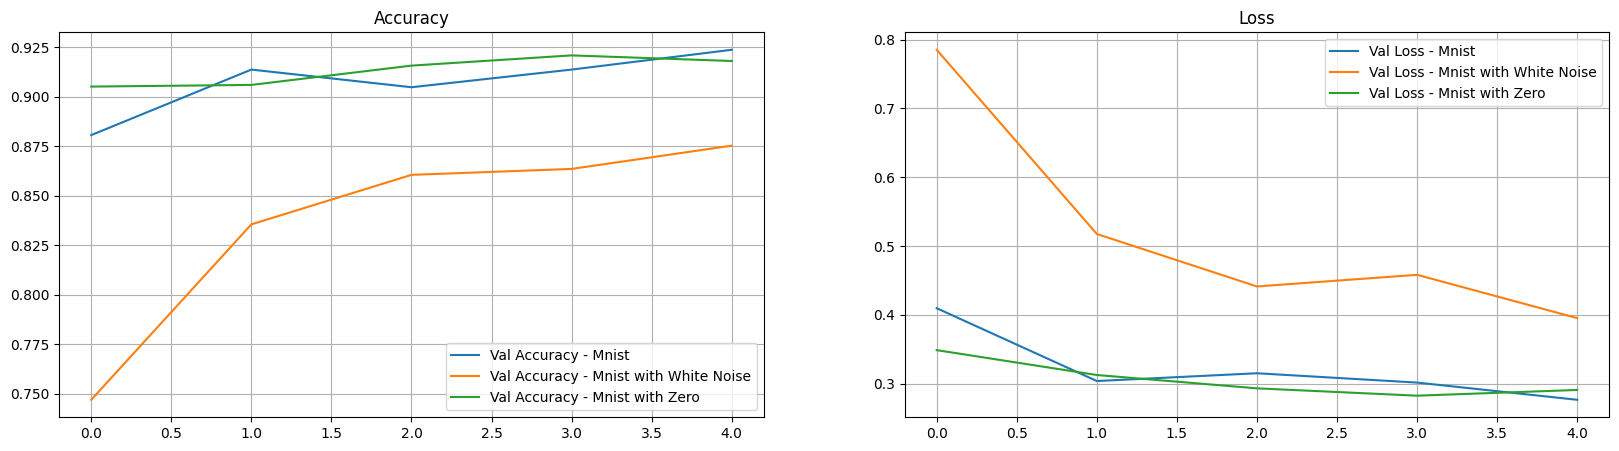

In [7]:
Common.plot(
    data=[history, white_history, zero_history],
    labels=["Mnist", "Mnist with White Noise", "Mnist with Zero"],
    only_val=True,
)

### <ins>**02. Manifold Hypothesis**</ins>


**Manifold:**
  - A low-dimensional representation (subspace) of a high-dimensional data structure
  - Non-latent — Non-essential features
  - Latent — Essential features
  
**Hypothesis:**
  - A manifold captures the latent pattern of raw high-dimensional dataset
  - Not all dimensions in raw data carry important information
  
**Effects on Machine Learning:**
  - Machine learning models only have to learn low-dimensional, highly structured subspaces
  - The new data has the same manifolds (latent structure) as of training data
  - Training must be stopped once those latent structures are learnt. Else:
    - Model starts learning non-essential features
    - Validation accuracy descreases
    - Model starts overfitting
  - Model may start learning non-latent features **before** learning latent features
    - That's why validation metric is important
  - Model must have a **continuous (differentiable)** mapping from inputs to outputs:
    - Otherwise gradient descent would not work

### <ins>**03. Training Data**</ins>

  - **Data curation** and **feature engineering** are essential for highly structured dataset
  - Machine learning can only perform **curve fitting** (non-linear interpolation)
  - Machine learning has no **reasoning** and **common sense**
  - Training data must be **densely sampled** (Fig. 5.11)

---
# **Model Evaluation**
---

### <ins>**01. Dataset Split**</ins>

##### **Holdout Validation**

**Code**

In [8]:
(samples, labels), _ = Chapter_01.dataset(False)
samples, labels = Common.shuffle_data(samples, labels)
x_train, y_train, x_val, y_val = Common.split_data(samples, labels)

**Problem**

- When dataset is very small, train/val division is not effective
- When different iterations of train/val dataset (each with shuffle) yields very different validation scores:
  - The dataset is not sufficient
  - Use K-Fold Cross Validation

##### **K-Fold Cross Validation**

> See section 02. Training with K-Fold Cross-Validation in Chapter 04

**Code**

In [9]:
(samples, labels), _ = Chapter_04.ScalarRegression.dataset()
samples, labels = Common.shuffle_data(samples, labels)

num_folds = 4
fold_size = len(samples) // num_folds
for fold_count in range(num_folds):
    train_samples, val_samples = Common.split_data_kfold(samples, fold_count, fold_size)
    # Labels using K-Fold
    train_labels, val_labels = Common.split_data_kfold(labels, fold_count, fold_size)
    # Create the model
    # Train the model
    # Evaluate the model
# Average the validation scores of all folds

##### **Iterative K-Fold Cross Validation**

**Note**
- Use **K-Fold Cross Validation** iteratively
- In each iteration, shuffle the dataset
- Average the results in the end
- Computationally expensive
  - **NxK** number of operations
  - N = Number of iterations
  - K = Number of folds


**Code**

In [10]:
(samples, labels), _ = Chapter_04.ScalarRegression.dataset()

num_iteration = 3

for iter_count in range(num_iteration):
    # Shuffle per iteration
    samples, labels = Common.shuffle_data(samples, labels)
    num_folds = 4
    fold_size = len(samples) // num_folds
    for fold_count in range(num_folds):
        train_samples, val_samples = Common.split_data_kfold(samples, fold_count, fold_size)
        # Labels using K-Fold
        train_labels, val_labels = Common.split_data_kfold(labels, fold_count, fold_size)
        # Create the model
        # Train the model
        # Evaluate the model
    # Average the validation scores of all folds
# Average the validation scores of all iterations

### <ins>**02. Information Leak:**

**Definition:**
  - Every time we change hyperparameters, some info of validation dataset is leaked into the model
  - That is, model learns about validation dataset without directly learning on it
  - That is the reason validation dataset is required along with test dataset 

**Note:**
  - Validation is a proxy (indirect) dataset to optimize hyperparemeters
  - Model should have no direct/indirect access to test dataset

### <ins>**03. Best Practices**</ins>

- For time series dataset, **don't** shuffle the dataset as order is important
- For other datasets, random shuffle dataset before train/val/test split
- Training and validation datasets should **not** have redundant info


---
# **Model Improvisation**
---

### <ins>**01. General**</ins>

**Problem scenarios:**
- Model training loss does not go down over time
- Model validation loss does not go down over time
- Model does not overfit over time

### <ins>**02. Gradient Descent Parameters**</ins>

**Dataset**

In [11]:
(train_samples, train_labels), (test_samples, test_labels) = Chapter_01.prepare()

**Incorrect learning rate**

In [12]:
model1 = Chapter_01.get_model(learning_rate=0.1)
history1 = Chapter_01.train(x=train_samples, y=train_labels, model=model1, epochs=10, val_percent=0.3)

**Correct learning rate**

In [13]:
model2 = Chapter_01.get_model(learning_rate=0.001)
history2 = Chapter_01.train(x=train_samples, y=train_labels, model=model2, epochs=10, val_percent=0.3)

**Exploration**

Metrics: 
loss, sparse_categorical_accuracy, val_loss, val_sparse_categorical_accuracy, 


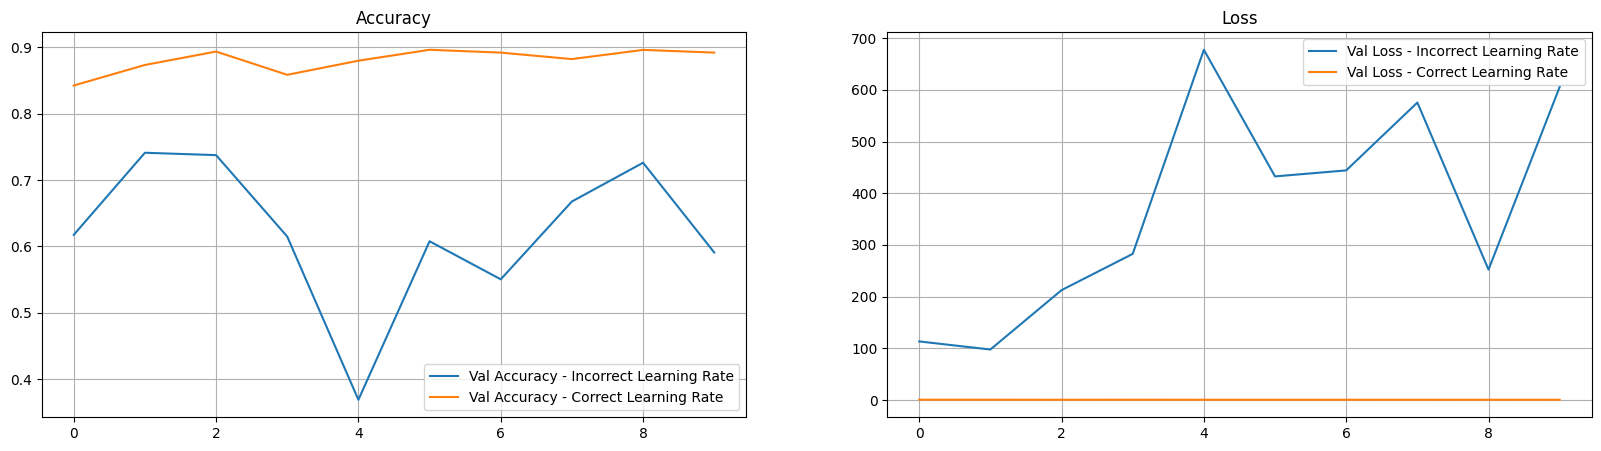

In [14]:
Common.plot(
    data=[history1, history2],
    labels=["Incorrect Learning Rate", "Correct Learning Rate"],
    only_val=True,
)

### <ins>**03. Architecture Priors**</ins>

**Problem**

- Training metrics are improving
- Validation/test metrics are not improving

**Cause**

| Cause | Detail |
| --- | --- |
| Dataset | Uninformative features | 
| Model | Dense, Conv, Recurrent, Transformer | 
| Training configuration | Loss function, Learning rate, Batch size | 

### <ins>**04. Model Capacity**</ins>

In [15]:
epochs = 10

**Small Model**

In [16]:
# Model size is too small to capture all information
# Training underfits
model1 = Chapter_01.get_small_model(learning_rate=0.001)
history1 = Chapter_01.train(x=train_samples, y=train_labels, model=model1, epochs=epochs, val_percent=0.3)

**Medium Model**

In [17]:
# Model size is sufficient to capture all information
model2 = Chapter_01.get_model(learning_rate=0.001)
history2 = Chapter_01.train(x=train_samples, y=train_labels, model=model2, epochs=epochs, val_percent=0.3)

**Large Model**

In [18]:
# Increasing the model size returns diminishing results
model3 = Chapter_01.get_large_model(learning_rate=0.001)
history3 = Chapter_01.train(x=train_samples, y=train_labels, model=model3, epochs=epochs, val_percent=0.3)

**Exploration**

Metrics: 
loss, sparse_categorical_accuracy, val_loss, val_sparse_categorical_accuracy, 


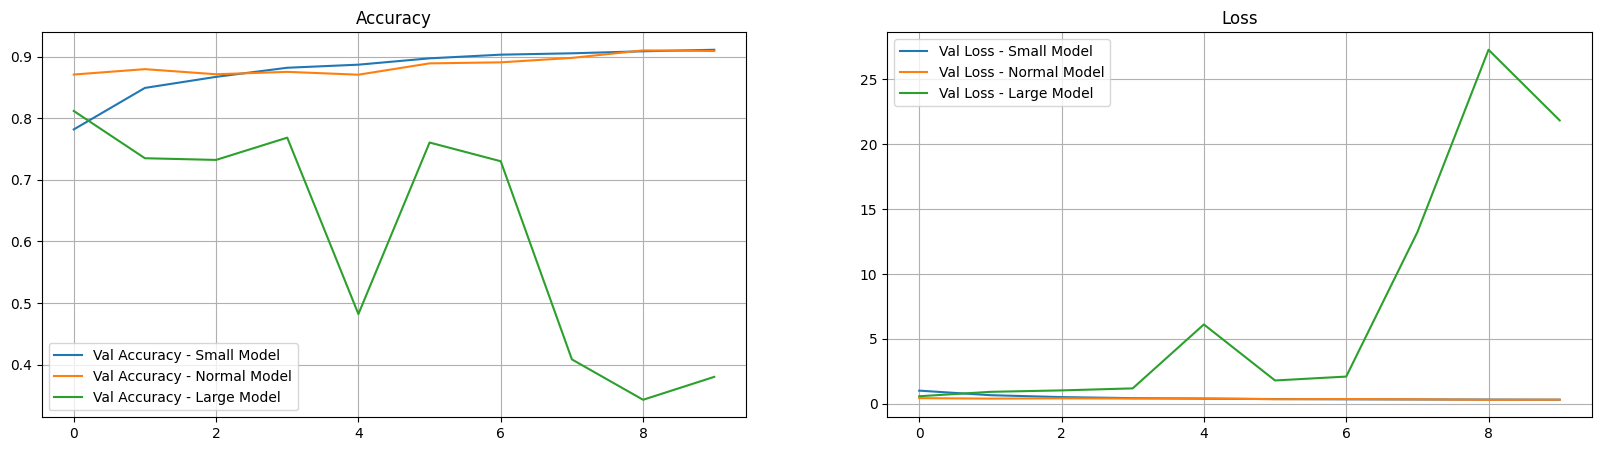

In [19]:
Common.plot(
    data=[history1, history2, history3],
    labels=["Small Model", "Normal Model", "Large Model"],
    only_val=True,
)

---
# **Model Advanced Generalization**
---

### <ins>**01. Dataset Curation**</ins>

- There must be a relation between inputs and outputs — Machine learning is curve fitting, not magic
- Increase size of the dataset
- Reduce errors in labelling
- Feature scaling

### <ins>**02. Feature Engineering**</ins>

**Example**

  - Tell the time by seeing image of clock
  - Option-1:
    - Use Conv network to predict time by performing image classification
  - Option-2:
    - Use image processing to get lines (and angles) of clock needles
    - Use simple neural network to perform scalar regression

**Note**
  - Good features require smaller neural network
  - Good features require fewer data samples

### <ins>**03. Early Stopping**</ins>

- Stop the training once the model starts overfitting
    - Validation accuracy decreases
    - Training accuracy stablizes
- Use **keras.callbacks.EarlyStopping**
  - It interrupts training when validation metrics stop improving
  - It returns model with best validation metrics

### <ins>**04. Regularization**</ins>

##### **i. Reduce Network Size**

| Topic | Detail |
| --- | --- |
| Correct model size | Model will learn **latent** features, improving validation metrics |
| Small model size | Model will not completely learn **latent** features |
| Large model size | Model will also learn **non-latent** features |
| Best practice | Start with fewer layers (tf.keras.layers) and fewer parameters (units) |

##### **ii. L1/L2 Regularization**

**Definition**:
- Apply penalty on larger weight updates
- For smaller models
- Only during training

**Occam's Razor:**
- Given two explanations for something, the simplest explanation is mostly likely to be correct.
- Simpler explanation makes fewer assumptions

**L1 Regularization:**
- Penalty is proportional to the **absolute** value of weight coefficient

**L2 Regularization:**
- Penalty is proportional to the **square** value of weight coefficient
- It is also called weight decay
- Example:
  - Weight decay = 0.002
  - Weight penalty = 0.002 * square(weight)

##### **iii. Dropout**

**Defition**:
| Topic | Detail |
| --- | --- |
| Dropout | To randomly set a portion of layer's output to zero |
| Rate | A percent of output to be dropped out  |
| Effect | It reduces overfitting |
| Note | Only for training |
| Note | For large models |

**Example**:

| Data | Value |
| --- | --- |
| Input | [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] |
| Rate | 0.5  |
| Output | [1, 0, 0, 4, 5, 0, 0, 8, 0, 10] |

##### **iv. Examples**

**Dataset**

In [20]:
(
    x_train,
    y_train,
    x_val,
    y_val,
    x_test,
    y_test,
) = Chapter_04.BinaryClassification.prepare()
epochs = 20

**Model with enough layers**

In [21]:
model1 = Chapter_04.BinaryClassification.get_model()
history1 = Chapter_04.BinaryClassification.train(x_train, y_train, x_val, y_val, model1, epochs)

**Model with many layers**

In [22]:
model2 = Chapter_04.BinaryClassification.get_large_model()
history2 = Chapter_04.BinaryClassification.train(x_train, y_train, x_val, y_val, model2, epochs)

**Model with regularization**

In [23]:
model3 = Chapter_04.BinaryClassification.get_model_with_regularization()
history3 = Chapter_04.BinaryClassification.train(x_train, y_train, x_val, y_val, model3, epochs)

**Model with dropout**

In [24]:
model4 = Chapter_04.BinaryClassification.get_model_with_dropout()
history4 = Chapter_04.BinaryClassification.train(x_train, y_train, x_val, y_val, model4, epochs)

**Exploration**

Metrics: 
loss, binary_accuracy, val_loss, val_binary_accuracy, 


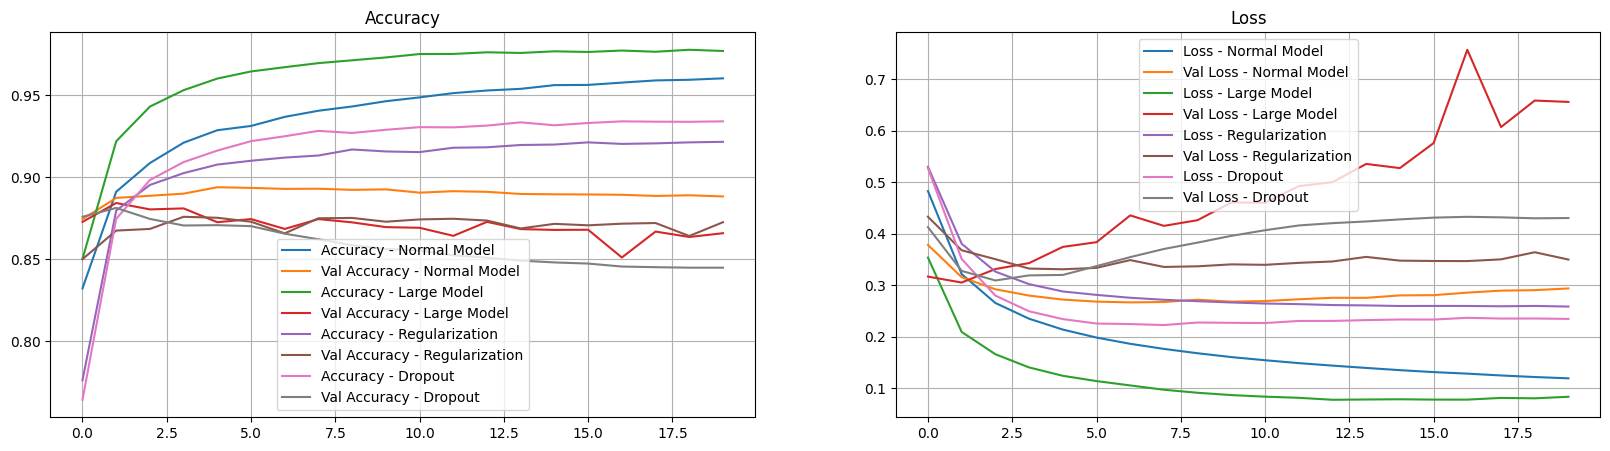

In [25]:
Common.plot(
    data=[history1, history2, history3, history4],
    labels=["Normal Model", "Large Model", "Regularization", "Dropout"],
)

---
---
---